In [ ]:
#!pip install scikit-plot
#!pip install google-cloud-storage
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import pickle
import os
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

In [ ]:
bucket_name = 'models_23423534535'

In [ ]:
dataset_dict = {}
dataset_name = ['NATURAL', 'RUS', 'SMOTE', 'SMOTE_ENN', 'TEST']

## Basic functions

In [ ]:
from google.cloud import storage

def read_from_gcs(file_name, type, bucket_name=bucket_name):
    """Read data from a public GCS bucket."""
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)

    if type == 'model':
        folder_name = 'models'
    elif type == "dataset":
        folder_name = 'datasets'
    else:
        folder_name = ''

    blob = bucket.blob(folder_name + '/' + file_name)
    temp_file = "/tmp/" + file_name  # Temporary location to download the file
    blob.download_to_filename(temp_file)

    # Load the data from the downloaded file
    X, y = load_data(temp_file)

    return X, y

def read_dataset_from_gcs(file_name, type, bucket_name=bucket_name):
    """Read data from a public GCS bucket."""
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)

    if type == 'model':
        folder_name = 'models'
    elif type == "dataset":
        folder_name = 'datasets'
    else:
        folder_name = ''

    print("Reading :", file_name , " from the folder: ", folder_name )

    blob = bucket.blob(folder_name + '/' + file_name)
    temp_file = "/tmp/" + file_name  # Temporary location to download the file
    blob.download_to_filename(temp_file)

    # Load the data from the downloaded file
    X, y = load_test_data(temp_file)

    return X, y

# Example usage
#data = read_from_gcs(bucket_name, file_name)
#print(data)


# def write_to_gcs(file_name, data, type, folder, bucket_name = bucket_name):
#     """Write data to a public GCS bucket."""
#     client = storage.Client.create_anonymous_client()
#     bucket = client.bucket(bucket_name)

# # example: models_23423534535/models/rus

#     if type == 'model':
#       folder_name = 'models' + '/' + folder
#     elif type == "dataset":
#       folder_name = 'datasets'
#     else:
#       folder_name = ''

#     blob = bucket.blob(folder_name + '/' + file_name)
#     blob.upload_from_file(file_name)

# # Example usage
# #data = "Hello, World!"
# #write_to_gcs(bucket_name, file_name, data)

## Helper functions

In [ ]:
import pickle

def load_data(file_name):
    try:
        with open(file_name, 'rb') as file:
            data = pickle.load(file)
        X = data['X_train']
        y = data['y_train']
        return X, y
    except KeyError:
        print("Error: The loaded dictionary does not contain the expected keys.")
        return None, None


In [ ]:
import pickle

def load_test_data(file_name):
    try:
        with open(file_name, 'rb') as file:
            data = pickle.load(file)
            print()
        X = data['X_test']
        y = data['y_test']
        return X, y
    except KeyError:
        print("Error: The loaded dictionary does not contain the expected keys.")
        return None, None

In [ ]:
def save_model_locally(model, X_train, y_train, folder):
    print("Now fitting the model.... ", model)
    model.fit(X_train, y_train)
    pickle.dump(model, open(folder,'wb'))
    print(f"Model {model} saved successfully.")

## Step 1 : Define the models that we will need

In [ ]:
models_list = [
    (DummyClassifier(strategy="most_frequent"), 'baseline_lnm.pkl', 'Zero R'),
    (BaggingClassifier(bootstrap=False, bootstrap_features=True), 'bagging_lnm.pkl', 'Bagging classifier'),
    (LogisticRegression(multi_class='multinomial', max_iter=3000), 'log_regression_lnm.pkl', 'Logistic Regression'),
    (RandomForestClassifier(n_estimators=100, random_state=42),'RandomForest_lnm.pkl', 'Random Forest'),
    (XGBClassifier(learning_rate=0.2), 'xgb_lnm.pkl', 'XGBBoost')
]


## Create models for Natural split dataset

In [ ]:
dataset_natural = 'bank_fraud_train_set_natural_2.pkl'
folder = '/content/natural/'
X_train,y_train = read_from_gcs(dataset_natural, 'dataset')
print("Size of X_train: ", len(X_train))
print("Size of y_train: " ,len(y_train))

dataset_dict['NATURAL'] = {'X_train': X_train, 'y_train': y_train}

Size of X_train:  200000
Size of y_train:  200000


In [ ]:
# Read test dataset from GCS
dataset_to_read = 'bank_fraud_test_set_2.pkl'
#X_test, y_test = read_dataset_from_gcs(dataset_to_read, 'dataset')

df_test = pd.read_pickle('/content/datasets/bank_fraud_test_set_2.pkl')

y_test = df_test['y_test']
X_test = df_test['X_test']

#dataset_dict['TEST'] = {'X_test': X_test, 'y_test': y_test}

In [ ]:
print(type(y_test))
print(type(X_test))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
import pandas as pd

# Assuming X_train and X_test are your pandas DataFrames containing the training and test data respectively
# You can print the column names of the training data like this:
#print("Column names of training X data:")
#print(X_train.columns, len(X_train.columns))

#print("Column names of testing X data:")
#print(X_test.columns, len(X_test.columns))

# print(X_train.info())

# print(X_test.info())

X_train.payment_type.value_counts()

# # Get the column names of the training data
# train_column_names = set(X_train.columns)

# # Get the column names of the test data
# test_column_names = set(X_test.columns)

# # Find the column names present in the training data but not in the test data
# columns_only_in_train = train_column_names - test_column_names

# # Find the column names present in the test data but not in the training data
# columns_only_in_test = test_column_names - train_column_names

# # Print the differences
# print("Column names only in training data:", columns_only_in_train)
# print("Column names only in test data:", columns_only_in_test)

AB    73780
AC    51457
AA    50719
AD    23999
AE       45
Name: payment_type, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create transformers for numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the preprocessing pipeline to the training data
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 237036 to 41331
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   income                            50000 non-null  float64 
 1   name_email_similarity             50000 non-null  float64 
 2   prev_address_months_count         50000 non-null  int64   
 3   current_address_months_count      50000 non-null  int64   
 4   customer_age                      50000 non-null  int64   
 5   days_since_request                50000 non-null  float64 
 6   intended_balcon_amount            50000 non-null  float64 
 7   payment_type                      50000 non-null  category
 8   zip_count_4w                      50000 non-null  int64   
 9   velocity_6h                       50000 non-null  float64 
 10  velocity_24h                      50000 non-null  float64 
 11  velocity_4w                       50000 non-null 

### Feature Names
When you use a ColumnTransformer with both a StandardScaler for numerical data and an OneHotEncoder for categorical data, the feature names after transformation are not preserved in the same format. The OneHotEncoder especially changes the feature names because it creates a binary column for each category in the original data.

Here's how you can get the feature names after such a transformation:

Get Feature Names for Numerical Columns: These will remain the same as the column names in the original dataset.

Get Feature Names for Categorical Columns: The OneHotEncoder will create new columns for each unique value in each categorical column. You can get these new feature names using the get_feature_names_out() method on the OneHotEncoder.

Then, you combine these two lists to create the full feature_names list. Here's how you can do it:

In [ ]:
# Create feature names so they can be used in SHAP later
# Get feature names for numerical columns
numerical_features = numerical_cols.tolist()

# Get feature names from the one hot encoder
# Note: In versions of scikit-learn prior to 0.24, use 'get_feature_names' instead of 'get_feature_names_out'
categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()

# Combine the feature names
feature_names = numerical_features + categorical_features

# print
print(feature_names)
print("Number of features: ", len(feature_names))

['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC', 'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG', 'source_INTERNET', 'source_TELEA

### Create model

In [ ]:
for clr, out_dir, _ in models_list:
    save_model_locally(clr, X_train_prepared, y_train, folder+out_dir)

## Create models for Random Under Sampler

In [ ]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

dataset_rus = 'bank_fraud_train_set_rus_2.pkl'
folder = '/content/rus/'
X_rus_train,y_rus_train = read_from_gcs(dataset_rus, 'dataset')
print(y_rus_train.value_counts())
dataset_dict['RUS'] = {'X_train': X_rus_train, 'y_train': y_rus_train }

0    8823
1    8823
Name: fraud_bool, dtype: int64


In [ ]:


# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create transformers for numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the preprocessing pipeline to the training data
X_rus_train_prepared = preprocessor.fit_transform(X_rus_train)
X_rus_test_prepared = preprocessor.transform(X_test)

In [ ]:

for clr, out_dir, _ in models_list:
    save_model_locally(clr, X_rus_train_prepared, y_rus_train, folder+out_dir)

In [ ]:
print(y_test.value_counts())
print(y_rus_train.value_counts())

# ({'0': 95.588, '1': 4.412}, {'0': 50.0, '1': 50.0})

0    47794
1     2206
Name: fraud_bool, dtype: int64
0    8823
1    8823
Name: fraud_bool, dtype: int64


In [ ]:
# # Assuming X_test and y_test are defined and models are defined
# warnings.filterwarnings('ignore')
# # Define lists of folder names and model names
# #folder_names = ["natural" , "rus", "smote", "smote_enn"]
# folder_names = ["/content/rus/"]
# model_names = ["baseline_lnm.pkl", "bagging_lnm.pkl", "log_regression_lnm.pkl","RandomForest_lnm.pkl","xgb_lnm.pkl"]

# # Create a list of tuples containing folder names and model names
# model_files = [(folder_name, model_name) for folder_name in folder_names for model_name in model_names]

# #print(model_files)

# # Loop over model_files and call evaluate_models
# for folder_name, model_name in model_files:
#     print(f"Evaluating model: {model_name} in folder: {folder_name}")
#     metrics = evaluate_models(model_name, X_rus_test_prepared, y_test, folder_name)
#     print(metrics)
#     print("\n")

# Create models for SMOTE

In [ ]:
dataset_rus = 'bank_fraud_train_set_smote_2.pkl'
folder = '/content/smote/'
X_sm_train,y_sm_train = read_from_gcs(dataset_rus, 'dataset')
dataset_dict['SMOTE'] = {'X_train': X_sm_train, 'y_train': y_sm_train }

In [ ]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create transformers for numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the preprocessing pipeline to the training data
X_smt_train_prepared = preprocessor.fit_transform(X_sm_train)
X_smt_test_prepared = preprocessor.transform(X_test)



In [ ]:
# Create model
for clr, out_dir, _ in models_list:
    save_model_locally(clr, X_smt_train_prepared, y_sm_train, folder+out_dir)

# Create models for SMOTE-ENN

In [ ]:
dataset_rus = 'bank_fraud_train_set_smote_enn_2.pkl'
folder = '/content/smote_enn/'
X_sme_train, y_sme_train = read_from_gcs(dataset_rus, 'dataset')
dataset_dict['SMOTE_ENN'] = {'X_train': X_sme_train, 'y_train': y_sme_train }

In [ ]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create transformers for numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the preprocessing pipeline to the training data
X_smte_train_prepared = preprocessor.fit_transform(X_sme_train)
X_smte_test_prepared = preprocessor.transform(X_test)


In [ ]:
# Create model
for clr, out_dir, _ in models_list:
    save_model_locally(clr, X_smte_train_prepared, y_sme_train, folder+out_dir)

# Ensamble Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

def read_model(folder_name, model_name):
  with open(folder_name+'/'+model_name, 'rb') as file:
              model = pickle.load(file)
  return model

logistic_model = LogisticRegression()
xgboost_model = XGBClassifier()
random_forest_model = RandomForestClassifier()
bagging_model = BaggingClassifier()

# Initialize the models
logistic_model = read_model('rus','log_regression_lnm.pkl')
xgboost_model = read_model('rus','xgb_lnm.pkl')
random_forest_model = read_model('rus', 'RandomForest_lnm.pkl')
bagging_model = read_model('rus','bagging_lnm.pkl')




In [ ]:
from sklearn.ensemble import VotingClassifier

# Create a voting classifier
ensemble_voting = VotingClassifier(estimators=[
    ('logistic', logistic_model),
    ('xgboost', xgboost_model),
    ('random_forest', random_forest_model),
    ('bagging', bagging_model)] , voting='soft')

# Train the ensemble model
ensemble_voting.fit(X_smt_train_prepared, y_sm_train)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(max_iter=3000,
                                                 multi_class='multinomial')),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            g...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('bagging',
                              BaggingClassifier(bootstrap=False,
                                                bootstrap_features=True))],
                 voting='soft')

In [ ]:
import pickle

pickle.dump(ensemble_voting, open('/content/rus/ensemble.pkl','wb'))

In [ ]:
file_path = '/content/rus/ensemble.pkl'

with open(file_path, 'rb') as file:
    ensemble_voting = pickle.load(file)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming `ensemble_model` is your trained ensemble model. It could be an instance of VotingClassifier, StackingClassifier, or any other classifier.
predictions = ensemble_voting.predict(X_test_prepared)

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.4f}')

# Precision, Recall, and F1-Score
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

print(classification_report(y_test, predictions))


Accuracy: 0.8758
Precision: 0.1932
Recall: 0.5716
F1-Score: 0.2888
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     47794
           1       0.19      0.57      0.29      2206

    accuracy                           0.88     50000
   macro avg       0.59      0.73      0.61     50000
weighted avg       0.94      0.88      0.90     50000



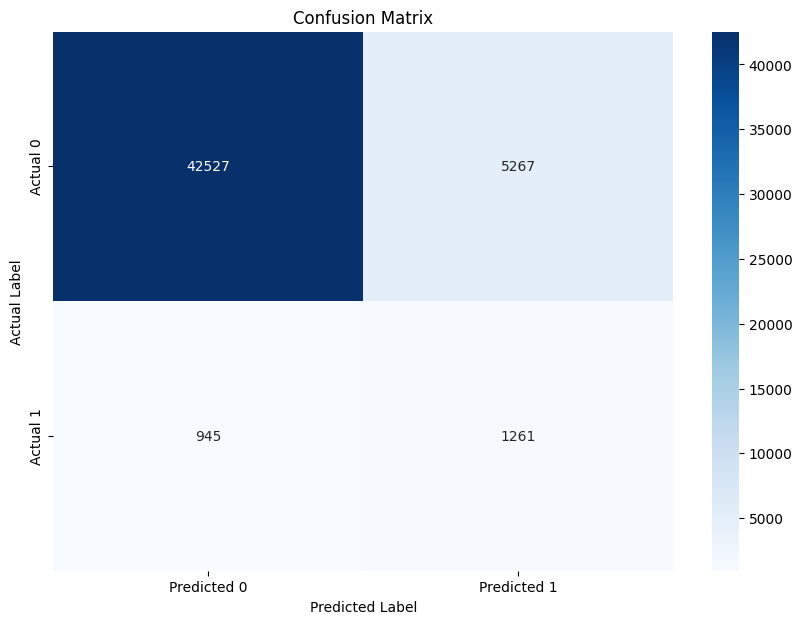

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Using Seaborn to create a more attractive confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import shap
import numpy as np


# Select a smaller, representative subset of your training data for explanation to enhance performance
X_explain_sample = pd.DataFrame(X_train_prepared, columns=feature_names)
X_explain_sample = shap.utils.sample(X_train_prepared, 100)

# Initialize SHAP's KernelExplainer with the ensemble model's predict function and the sampled data
explainer = shap.KernelExplainer(model=ensemble_voting.predict, data=X_explain_sample)

# For performance reasons, compute SHAP values on a smaller subset of your test data
X_test_sample = shap.utils.sample(X_test_prepared, 10)

# Compute SHAP values for the sampled test data
shap_values = explainer.shap_values(X=X_test_sample)


  0%|          | 0/10 [00:00<?, ?it/s]

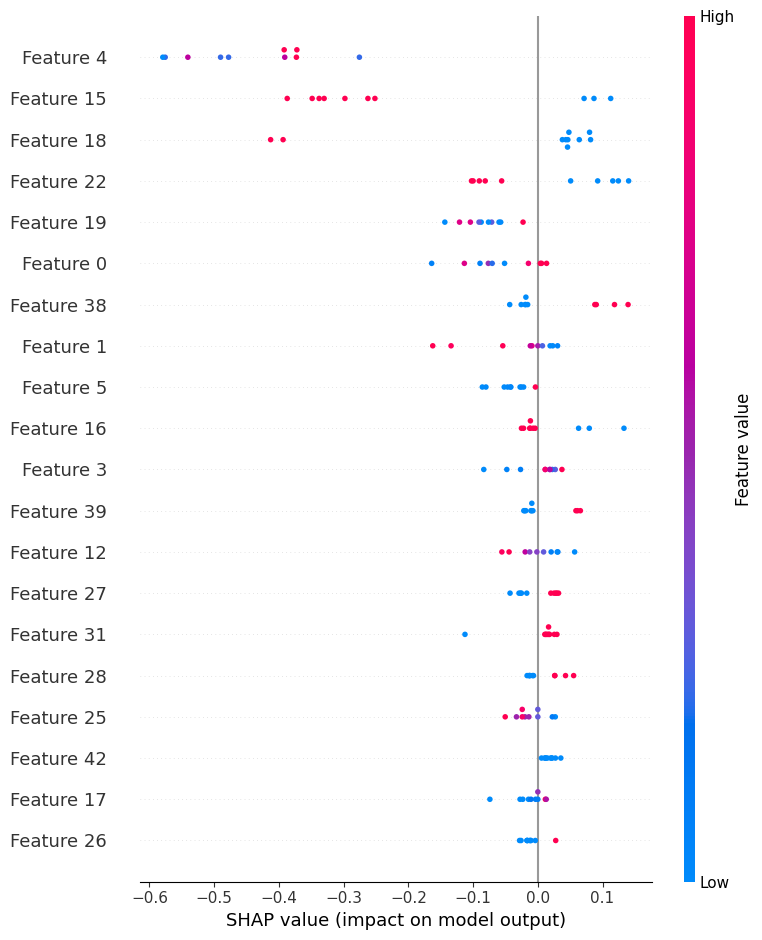

In [ ]:
# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test_sample)

# Performance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pickle
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import shap

warnings.filterwarnings('ignore')


def evaluate_model_average_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    #plot_confusion_matrix(y_test, y_pred, model)

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

def evaluate_models(X_test, y_test, folder_name):
    model_names = ["baseline_lnm.pkl", "bagging_lnm.pkl", "log_regression_lnm.pkl","RandomForest_lnm.pkl","xgb_lnm.pkl"]
    metrics_df = pd.DataFrame()
    metrics_list = []


    for model_name in model_names:
      print(f"Evaluating model: {model_name} in folder: {folder_name}")
      try:
          # Attempt to load the model
          with open(folder_name+'/'+model_name, 'rb') as file:
              model = pickle.load(file)
          print(f"Model loaded successfully: {model_name}")

          metrics = evaluate_model_average_performance(model, X_test, y_test)
          metrics_list.append({'Model Name': model_name, **metrics})  # Include model name in metrics dictionary
          metrics_df = metrics_df.append(pd.DataFrame(metrics, index=[model_name]))



          # Predict probabilities and calculate ROC AUC
          y_prob = model.predict_proba(X_test)[:, 1]
          fpr, tpr, _ = roc_curve(y_test, y_prob)
          roc_auc = auc(fpr, tpr)

          # Plotting the ROC curve for the current model
          plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
      except Exception as e:
          print(f"Error processing {model_name}: {e}")


    dataset = folder_name.split("/")[-2].upper()
    metrics_list = pd.DataFrame(metrics_list)

    dataset_seq = 0
    if dataset == 'RUS':
      dataset_seq = 1
    elif dataset == 'SMOTE':
      dataset_seq = 2
    elif dataset == 'SMOTE_ENN':
      dataset_seq = 3

    metrics_list['Source'] = dataset_seq

    # Displaying metrics DataFrame with styling
    pd.options.display.float_format = '{:,.2f}'.format
    styled_df = metrics_df.style.background_gradient(cmap='Set2') \
        .set_table_attributes('style="border-collapse: collapse; border: 1px solid black;"') \
        .format("{:.2f}")
    display(styled_df)

    # Plot AUC
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models in: ' + dataset + ' Dataset')
    plt.legend(loc="lower right")
    plt.show()

    return metrics_list

def plot_confusion_matrix(y_true, y_pred, model_name, return_cm=False):
    """
    Generates and displays a confusion matrix for the given true and predicted labels.

    Parameters:
    - y_true: array-like of shape (n_samples,) - True labels.
    - y_pred: array-like of shape (n_samples,) - Predicted labels.
    - model_name: str - Name of the model (for title display).
    - return_cm: bool - Whether to return the confusion matrix data (default is False).

    Returns:
    - cm: The confusion matrix array if return_cm is True. Otherwise, nothing is returned.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # Plotting
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, values_format='d')
    ax.set_title(f'{model_name} Confusion Matrix')
    plt.show()

    if return_cm:
        return cm

Evaluating model: baseline_lnm.pkl in folder: /content/natural/
Model loaded successfully: baseline_lnm.pkl
Evaluating model: bagging_lnm.pkl in folder: /content/natural/
Model loaded successfully: bagging_lnm.pkl
Evaluating model: log_regression_lnm.pkl in folder: /content/natural/
Model loaded successfully: log_regression_lnm.pkl
Evaluating model: RandomForest_lnm.pkl in folder: /content/natural/
Model loaded successfully: RandomForest_lnm.pkl
Evaluating model: xgb_lnm.pkl in folder: /content/natural/
Model loaded successfully: xgb_lnm.pkl


,Accuracy,Precision,Recall,F1 Score
baseline_lnm.pkl,0.96,0.00,0.00,0.00
bagging_lnm.pkl,0.96,0.54,0.07,0.13
log_regression_lnm.pkl,0.96,0.60,0.14,0.22
RandomForest_lnm.pkl,0.96,0.70,0.07,0.13
xgb_lnm.pkl,0.96,0.57,0.20,0.29


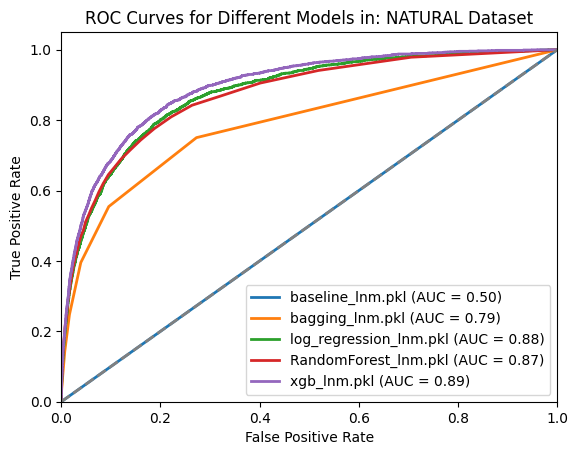



Evaluating model: baseline_lnm.pkl in folder: /content/rus/
Model loaded successfully: baseline_lnm.pkl
Evaluating model: bagging_lnm.pkl in folder: /content/rus/
Model loaded successfully: bagging_lnm.pkl
Evaluating model: log_regression_lnm.pkl in folder: /content/rus/
Model loaded successfully: log_regression_lnm.pkl
Evaluating model: RandomForest_lnm.pkl in folder: /content/rus/
Model loaded successfully: RandomForest_lnm.pkl
Evaluating model: xgb_lnm.pkl in folder: /content/rus/
Model loaded successfully: xgb_lnm.pkl


,Accuracy,Precision,Recall,F1 Score
baseline_lnm.pkl,0.96,0.00,0.00,0.00
bagging_lnm.pkl,0.83,0.20,0.95,0.33
log_regression_lnm.pkl,0.80,0.16,0.79,0.26
RandomForest_lnm.pkl,0.83,0.20,0.96,0.33
xgb_lnm.pkl,0.82,0.19,0.90,0.31


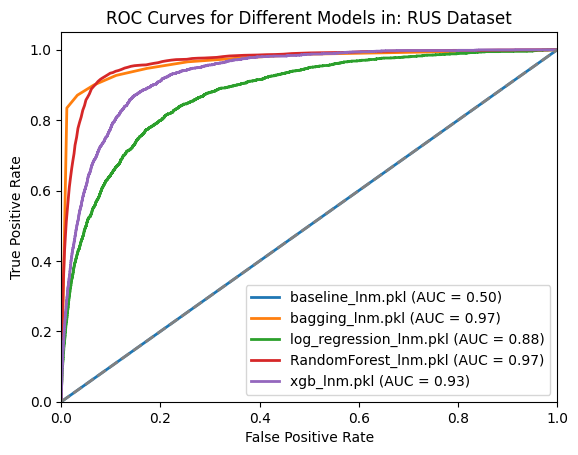



Evaluating model: baseline_lnm.pkl in folder: /content/smote/
Model loaded successfully: baseline_lnm.pkl
Evaluating model: bagging_lnm.pkl in folder: /content/smote/
Model loaded successfully: bagging_lnm.pkl
Evaluating model: log_regression_lnm.pkl in folder: /content/smote/
Model loaded successfully: log_regression_lnm.pkl
Evaluating model: RandomForest_lnm.pkl in folder: /content/smote/
Model loaded successfully: RandomForest_lnm.pkl
Evaluating model: xgb_lnm.pkl in folder: /content/smote/
Model loaded successfully: xgb_lnm.pkl


,Accuracy,Precision,Recall,F1 Score
baseline_lnm.pkl,0.96,0.00,0.00,0.00
bagging_lnm.pkl,0.95,0.37,0.15,0.21
log_regression_lnm.pkl,0.86,0.17,0.56,0.26
RandomForest_lnm.pkl,0.94,0.28,0.30,0.29
xgb_lnm.pkl,0.95,0.40,0.30,0.34


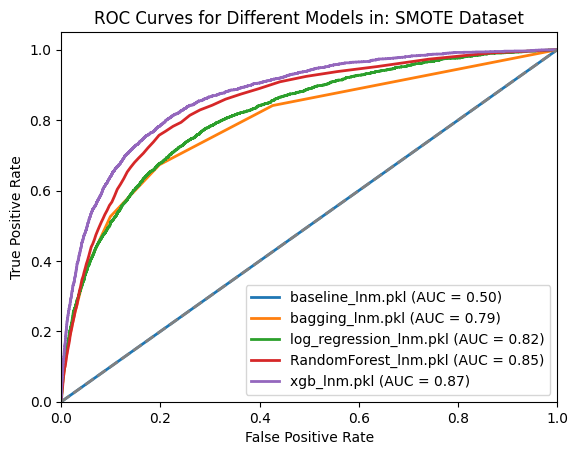



Evaluating model: baseline_lnm.pkl in folder: /content/smote_enn/
Model loaded successfully: baseline_lnm.pkl
Evaluating model: bagging_lnm.pkl in folder: /content/smote_enn/
Model loaded successfully: bagging_lnm.pkl
Evaluating model: log_regression_lnm.pkl in folder: /content/smote_enn/
Model loaded successfully: log_regression_lnm.pkl
Evaluating model: RandomForest_lnm.pkl in folder: /content/smote_enn/
Model loaded successfully: RandomForest_lnm.pkl
Evaluating model: xgb_lnm.pkl in folder: /content/smote_enn/
Model loaded successfully: xgb_lnm.pkl


,Accuracy,Precision,Recall,F1 Score
baseline_lnm.pkl,0.96,0.00,0.00,0.00
bagging_lnm.pkl,0.95,0.37,0.15,0.21
log_regression_lnm.pkl,0.88,0.19,0.50,0.27
RandomForest_lnm.pkl,0.93,0.28,0.31,0.29
xgb_lnm.pkl,0.95,0.40,0.26,0.32


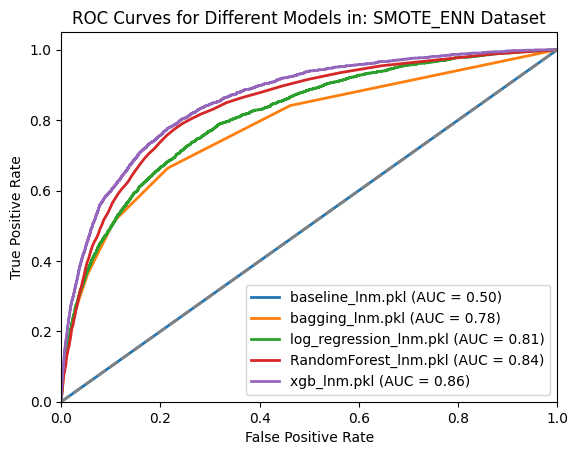



                Model Name  Accuracy  Precision  Recall  F1 Score  Source
0         baseline_lnm.pkl      0.96       0.00    0.00      0.00       0
1          bagging_lnm.pkl      0.96       0.54    0.07      0.13       0
2   log_regression_lnm.pkl      0.96       0.60    0.14      0.22       0
3     RandomForest_lnm.pkl      0.96       0.70    0.07      0.13       0
4              xgb_lnm.pkl      0.96       0.57    0.20      0.29       0
5         baseline_lnm.pkl      0.96       0.00    0.00      0.00       1
6          bagging_lnm.pkl      0.83       0.20    0.95      0.33       1
7   log_regression_lnm.pkl      0.80       0.16    0.79      0.26       1
8     RandomForest_lnm.pkl      0.83       0.20    0.96      0.33       1
9              xgb_lnm.pkl      0.82       0.19    0.90      0.31       1
10        baseline_lnm.pkl      0.96       0.00    0.00      0.00       2
11         bagging_lnm.pkl      0.95       0.37    0.15      0.21       2
12  log_regression_lnm.pkl      0.86

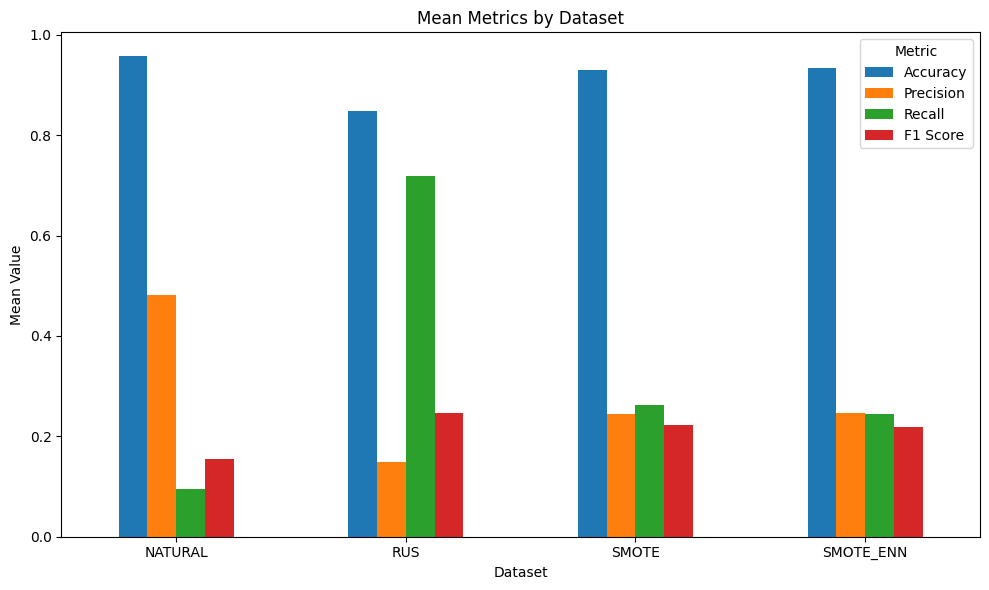

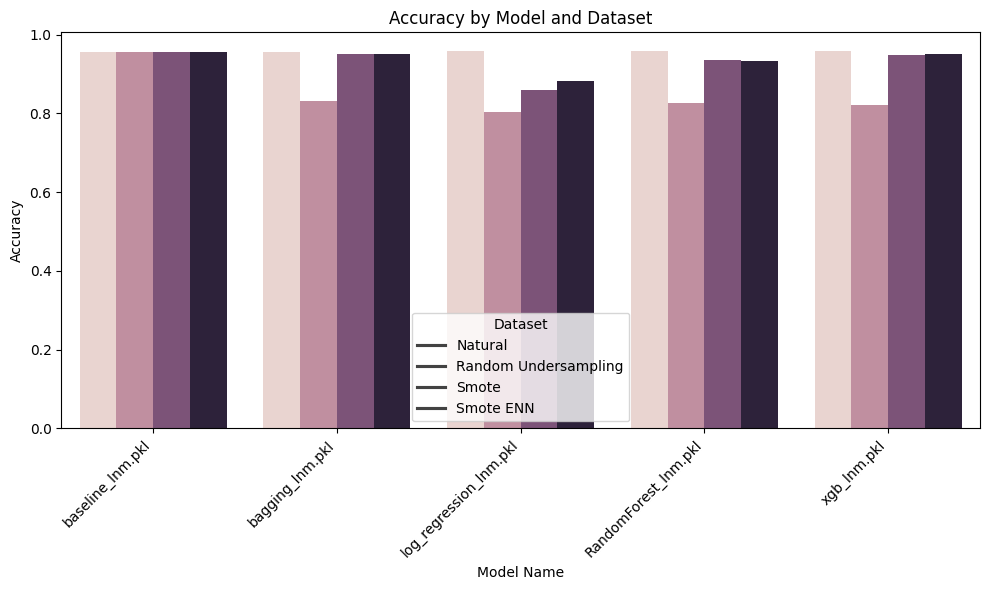

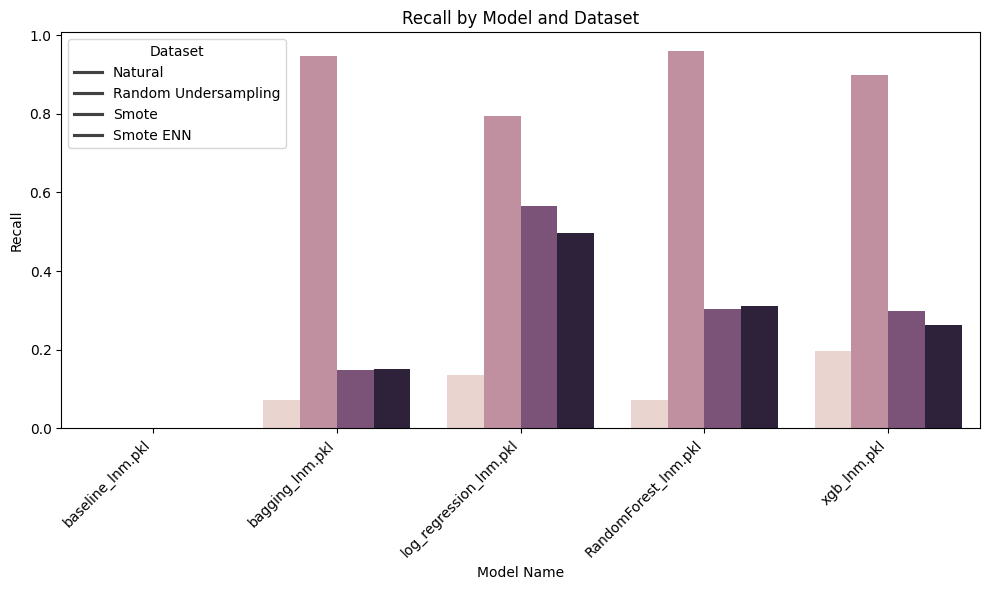

In [ ]:
import seaborn as sns


# Assuming X_test and y_test are defined and models are defined
warnings.filterwarnings('ignore')
# Define lists of folder names and model names
folder_names = ["/content/natural/", "/content/rus/", "/content/smote/","/content/smote_enn/"]
# Define X_test for each dataset
X_tests_prepared = [X_test_prepared, X_rus_test_prepared,X_smt_test_prepared, X_smte_test_prepared ]
datasets = ['Natural', 'Random Undersampling','Smote','Smote ENN']

# Initialize an empty DataFrame to store all metrics
all_metrics_df = pd.DataFrame()

# Loop over model_files and call evaluate_models
# Loop over model_files and call evaluate_models
for folder_name, X_test_prepared in zip(folder_names, X_tests_prepared):
    metrics  = evaluate_models(X_test_prepared, y_test, folder_name)
    all_metrics_df = all_metrics_df.append(metrics, ignore_index=True)

    # Print a newline for separation between different folders
    print("\n")

print(all_metrics_df)

# Print all_metrics_df bar chart


source_map = {0: 'NATURAL', 1: 'RUS', 2: 'SMOTE', 3: 'SMOTE_ENN'}
all_metrics_df['Source_Index'] = all_metrics_df['Source'].map(source_map)

# Group the data by 'Source_Index' column and calculate the mean of each metric
grouped_metrics = all_metrics_df.groupby('Source_Index').mean()
grouped_metrics = grouped_metrics[['Accuracy', 'Precision', 'Recall', 'F1 Score']]

# Plotting the bar chart
grouped_metrics.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Metrics by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Mean Value')
plt.legend(title='Metric')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Define the order of models for better visualization
model_order = ["baseline_lnm.pkl", "bagging_lnm.pkl", "log_regression_lnm.pkl", "RandomForest_lnm.pkl", "xgb_lnm.pkl"]
sns.set_palette("pastel")
# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=all_metrics_df, x='Model Name', y='Accuracy', hue='Source', order=model_order)
plt.title('Accuracy by Model and Dataset')
plt.xlabel('Model Name')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(datasets, title='Dataset')
plt.tight_layout()
plt.show()


# Define the order of models for better visualization
model_order = ["baseline_lnm.pkl", "bagging_lnm.pkl", "log_regression_lnm.pkl", "RandomForest_lnm.pkl", "xgb_lnm.pkl"]
sns.set_palette("pastel")
# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=all_metrics_df, x='Model Name', y='Recall', hue='Source', order=model_order)
plt.title('Recall by Model and Dataset')
plt.xlabel('Model Name')
plt.ylabel('Recall')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(datasets, title='Dataset')
plt.tight_layout()
plt.show()



In [ ]:
# Print the keys (dataset names)
print(dataset_dict.keys())

# Access a specific dataset
dataset_names = ['Natural', 'TEST', 'RUS', 'SMOTE', 'SMOTE_ENN']
# Iterate over dataset keys
# Iterate over keys and values in the dataset_dict
for dataset_name, dataset in dataset_dict.items():
   if 'test' in dataset_name.lower():  # Check if the key contains 'test' to access testing data
        X_test = dataset['X_test']
        y_test = dataset['y_test']
        total_samples = len(X_test) + len(y_test)  # Calculate the total number of samples
        print(f"Number of samples in the {dataset_name} dataset: X_test: {len(X_test)} and y_test: {len(y_test)}, total: {total_samples}")
   else:
        X_train = dataset['X_train']
        y_train = dataset['y_train']
        total_samples = len(X_train) + len(y_train)  # Calculate the total number of samples
        print(f"Number of samples in the {dataset_name} dataset: X_train: {len(X_train)} and y_train: {len(y_train)}, total: {total_samples}")

    #print(f"Number of samples in the {dataset_name} dataset: {len(X_train)}")


dict_keys(['Natural', 'TEST', 'RUS', 'SMOTE', 'SMOTE_ENN'])
Number of samples in the Natural dataset: X_train: 200000 and y_train: 200000, total: 400000
Number of samples in the TEST dataset: X_test: 50000 and y_test: 50000, total: 100000
Number of samples in the RUS dataset: X_train: 17646 and y_train: 17646, total: 35292
Number of samples in the SMOTE dataset: X_train: 382354 and y_train: 382354, total: 764708
Number of samples in the SMOTE_ENN dataset: X_train: 375532 and y_train: 375532, total: 751064


# SHAP

In [ ]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


0.8399999999999999

In [ ]:
# import pickle
# import shap
# import xgboost as xgb
# from tqdm.notebook import tqdm


# # Assuming feature_names is a list of your actual feature names
# X_test_shap = pd.DataFrame(X_test_prepared, columns=feature_names)
# #X_test_shap.info()
# #print(X_test_prepared.info())
# # Assuming your dataset_dict is correctly defined elsewhere

# # for dataset_name, dataset in dataset_dict.items():
# #     if 'test' in dataset_name.lower():
# #         X_test = dataset['X_test']

# with open('/content/smote/xgb_lnm.pkl', 'rb') as file:
#     model = pickle.load(file)

# # # Define a wrapper function for the XGBoost model
# # def predict_fn(X):
# #     return model.predict_proba(X)[:, 1]

# # Initialize the SHAP explainer with the wrapper function
# explainer = shap.TreeExplainer(model, model_output="probability", feature_perturbation="interventional", approximate=True)

# # Compute SHAP values
# shap_values_all = explainer(X_test_shap)

# # Plot the SHAP summary plot
# shap.summary_plot(shap_values_all, X_test_shap)



100%|===================| 49869/50000 [03:50<00:00]       

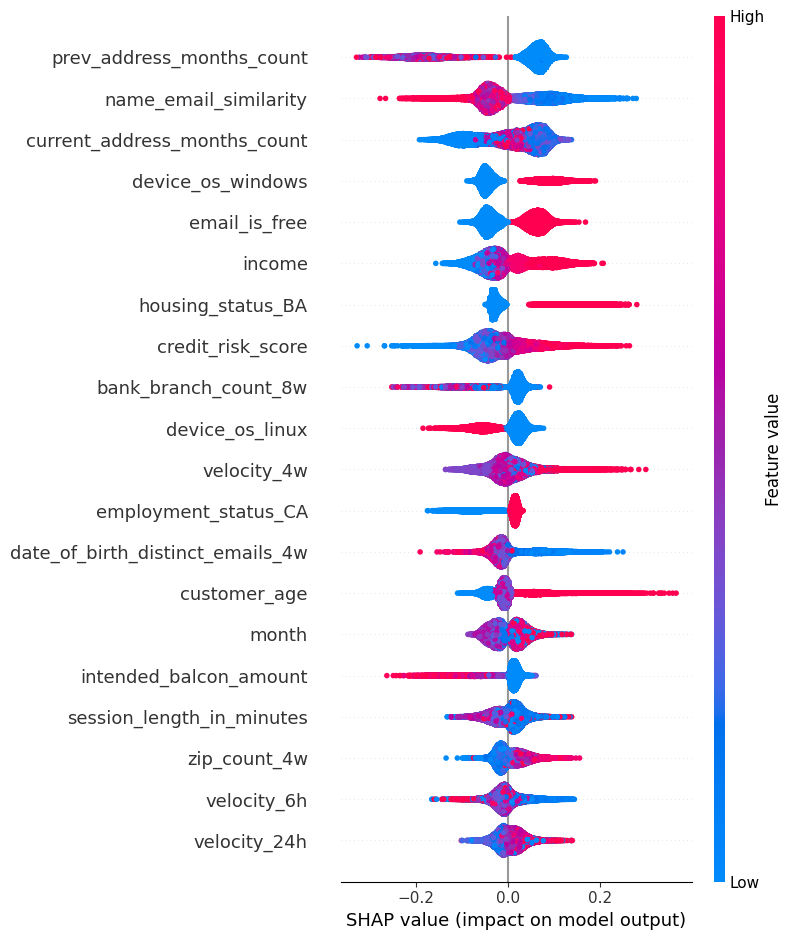

In [ ]:
import pandas as pd
import pickle
import shap

# Load the model
with open('/content/rus/xgb_lnm.pkl', 'rb') as file:
    model = pickle.load(file)

# Check if your model can be accelerated by GPU prediction
# model.set_param({'predictor': 'gpu_predictor'})

# Convert the numpy array to a DataFrame with feature names
X_test_shap = pd.DataFrame(X_test_prepared, columns=feature_names)

# Use TreeExplainer for a tree-based model like XGBoost
explainer = shap.TreeExplainer(model, X_test_shap, model_output="probability", feature_perturbation="interventional", approximate=True)



# Compute SHAP values (this may take some time depending on the size of your data and complexity of your model)
shap_values_all = explainer.shap_values(X_test_shap)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_all, X_test_shap)


In [ ]:
print(X_test_prepared.shape)
print(shap_values_all.shape)




(50000, 52)
(50000, 52)


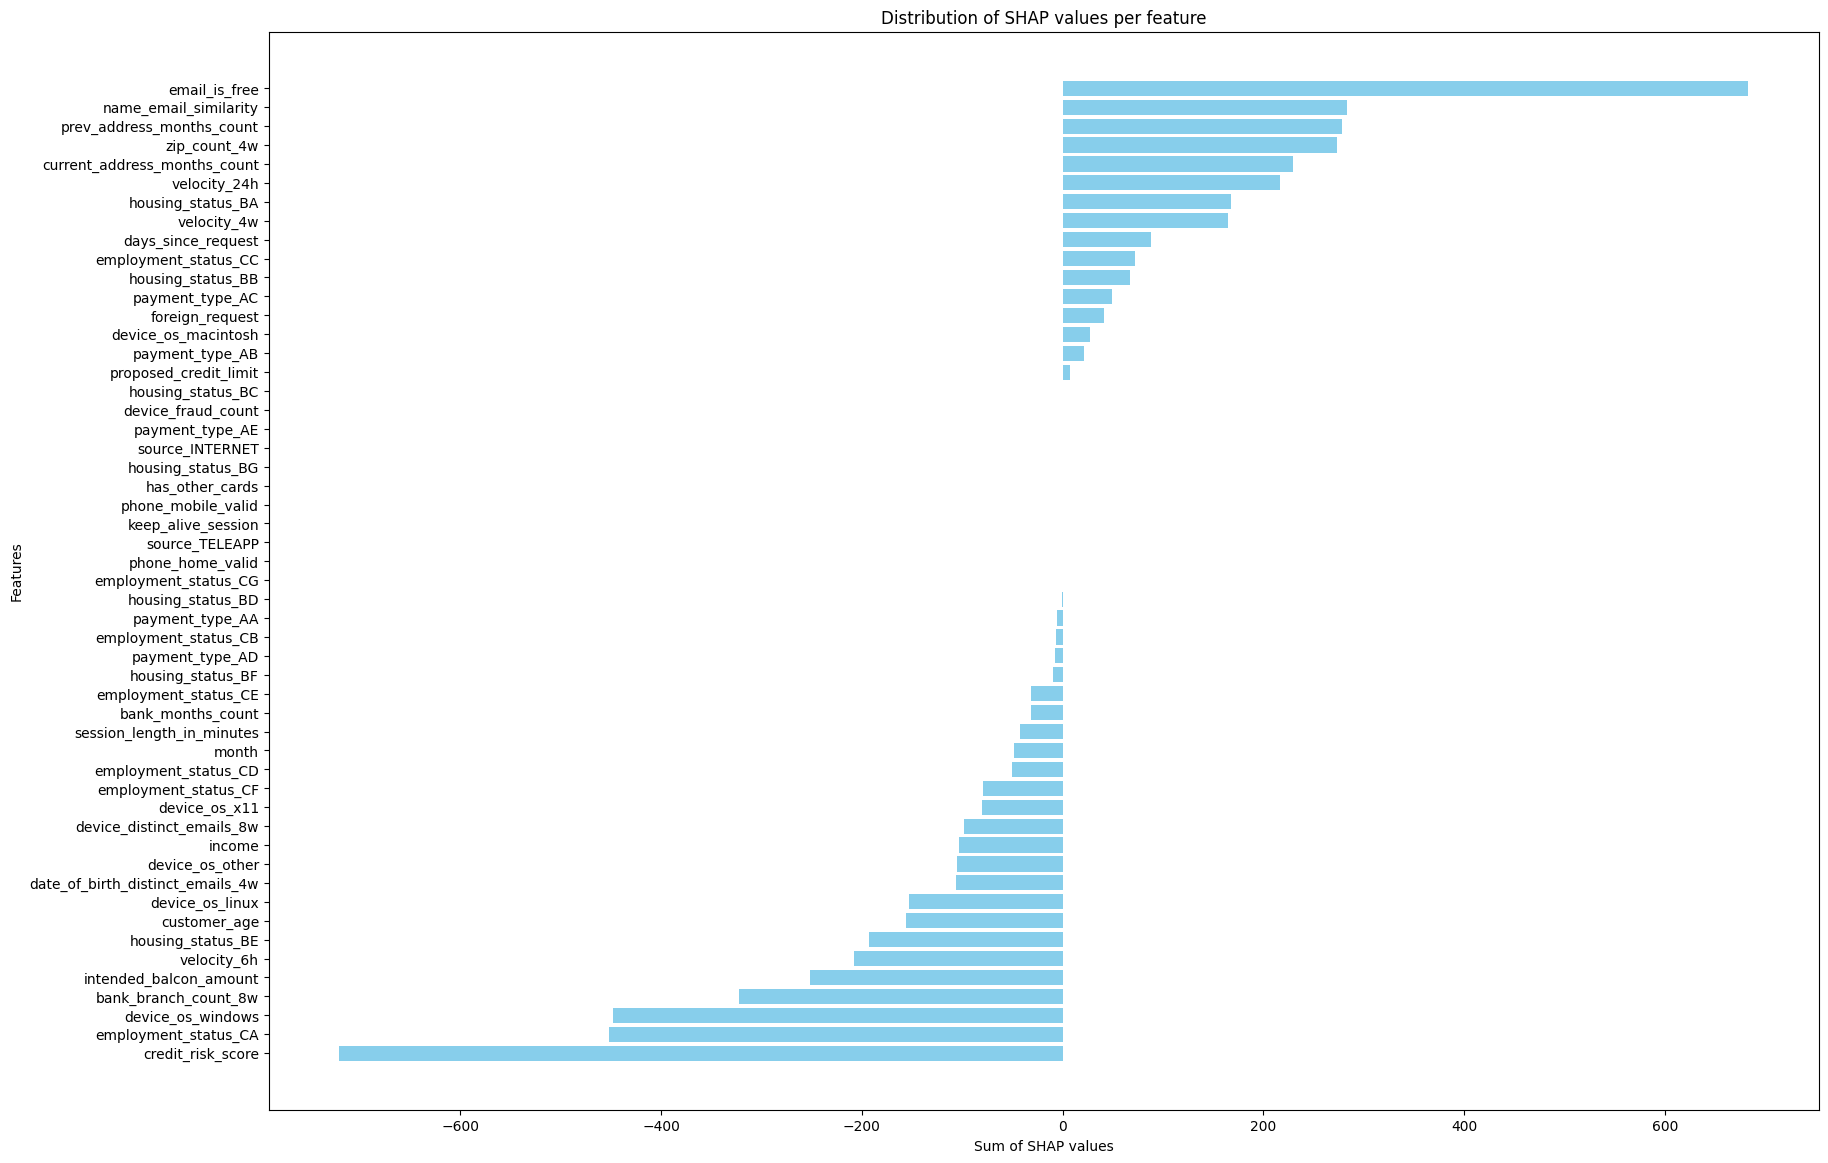

In [ ]:
type(shap_values_all)

# Summing SHAP values across all samples to get the average impact for each feature.
shap_sum = np.sum(shap_values_all, axis=0)

# Sorting features by their total SHAP value impact.
sorted_indices = np.argsort(shap_sum)
sorted_feature_names = np.array(feature_names)[sorted_indices]
sorted_shap_sum = shap_sum[sorted_indices]

# Plotting the histogram of SHAP sums with feature names.
plt.figure(figsize=(20, 14))
plt.barh(sorted_feature_names, sorted_shap_sum, color='skyblue')
plt.xlabel('Sum of SHAP values')
plt.ylabel('Features')
plt.title('Distribution of SHAP values per feature')
plt.show()

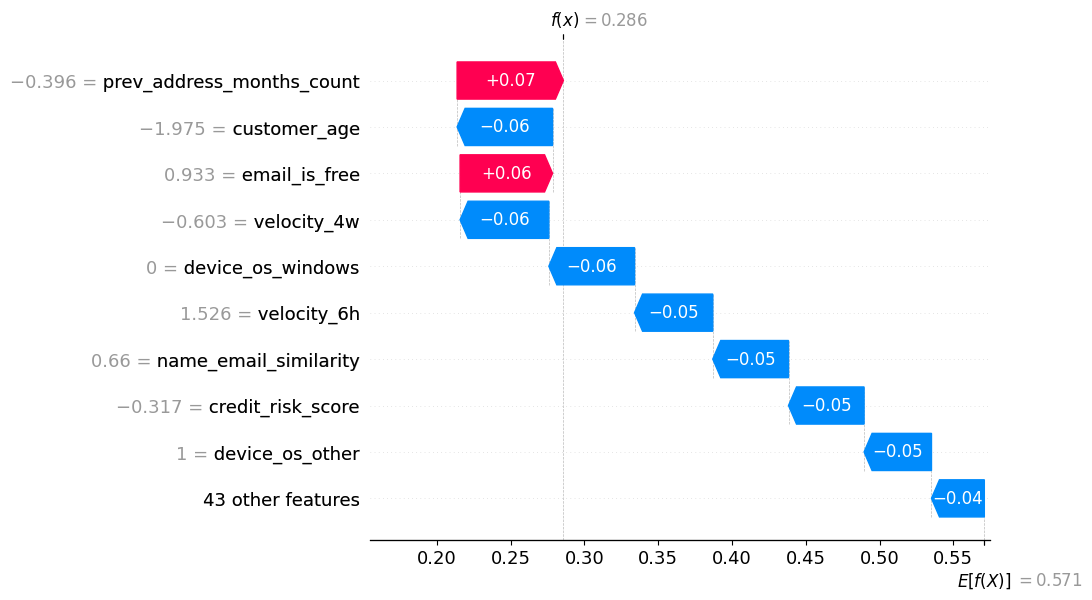

Actual test record: income                                       0.4
name_email_similarity                   0.681183
prev_address_months_count                     -1
current_address_months_count                 262
customer_age                                  10
days_since_request                      0.000032
intended_balcon_amount                      -1.0
payment_type                                  AB
zip_count_4w                                1225
velocity_6h                         10258.152865
velocity_24h                         4500.840135
velocity_4w                          4296.725517
bank_branch_count_8w                          15
date_of_birth_distinct_emails_4w              10
employment_status                             CA
credit_risk_score                            110
email_is_free                                  1
housing_status                                BB
phone_home_valid                               0
phone_mobile_valid                             1


In [ ]:
# Calculate SHAP values if you haven't already
#shap_values = explainer.shap_values(X_test_shap)

X_test_shap = pd.DataFrame(X_test_prepared, columns=feature_names)

# Create an Explanation object
explanation = shap.Explanation(values=shap_values_all[1099],
                               base_values=explainer.expected_value,
                               data=X_test_shap.iloc[1099],
                               feature_names=feature_names)

# Now you can create a waterfall plot for a single prediction
shap.waterfall_plot(explanation)

# Print the actual test record used for the Explanation object
print("Actual test record:", X_test.iloc[1099])



In [ ]:
y_test.loc[[166068]]

166068    1
Name: fraud_bool, dtype: int64

In [ ]:
X_test_shap.index = y_test.index

In [ ]:

# Load the model , identifying non-fraud/authentic records
with open('/content/rus/xgb_lnm.pkl', 'rb') as file:
    model = pickle.load(file)

# Assume that model.predict(X_test) will give you the predictions for the X_test data.
predictions = model.predict(X_test_prepared)

print("Does y_test have any Nan ? : ", y_test.isna())

df_new = pd.DataFrame({
    'y_test': y_test,
    'predictions': predictions
})

# print("Any na in df_new? :", df_new.isna())

# # Ensure that 'y_test' and 'predictions' have the same length as 'df_pred'
# if len(y_test) == len(df_new) and len(predictions) == len(df_new):
#     df_pred['y_test'] = y_test
#     df_pred['predictions'] = predictions
#     print("y_test and predictions have same length")
# else:
#     print("Length mismatch detected!")

#print("Does y_test have any Nan ? : ", df_new.isna() )

print("df_new: ", df_new.value_counts())

#df_new
tp_condition = (df_new['predictions'] == 1) & (df_new['y_test'] == 1)
X_tp = df_new[tp_condition]
print("True positive PD series size: ", len(X_tp))

tn_condition = (df_new['predictions'] == 0) & (df_new['y_test'] == 0)
X_tn = df_new[tn_condition]
print("True negative PD series size: ", len(X_tn))

fp_condition = (df_new['predictions'] == 1) & (df_new['y_test'] == 0)
X_fp = df_new[fp_condition]
print("False positive PD series size: ", len(X_fp))

fn_condition = (df_new['predictions'] == 0) & (df_new['y_test'] == 1)
X_fn = df_new[fn_condition]
print("False negative PD series size: ", len(X_fn))







# Print the actual test record used for the Explanation object
#print("Actual test record:", X_test.iloc[6])


# # Now, find the index of a record with a prediction indicating 'no fraud'
# no_fraud_indices = [i for i, pred in enumerate(predictions) if pred < 0.5]

# # If you want to see the first such record:
# if no_fraud_indices:
#     first_no_fraud_index = no_fraud_indices[0]
#     explanation = shap.Explanation(values=shap_values_all[first_no_fraud_index],
#                                    base_values=explainer.expected_value,
#                                    data=X_test_shap.iloc[first_no_fraud_index],
#                                    feature_names=feature_names)
#     shap.waterfall_plot(explanation)
#     print(f"SHAP values for the first 'no fraud' record (index {first_no_fraud_index}):", shap_values[first_no_fraud_index])
#     print("Actual test record for 'no fraud':", X_test.iloc[first_no_fraud_index])
# else:
#     print("No 'no fraud' records found.")


Does y_test have any Nan ? :  237036    False
47444     False
89797     False
137100    False
15502     False
          ...  
227792    False
157761    False
171718    False
237470    False
41331     False
Name: fraud_bool, Length: 50000, dtype: bool
df_new:  y_test  predictions
0       1              26090
        0              21704
1       1               2134
        0                 72
dtype: int64
True positive PD series size:  2134
True negative PD series size:  21704
False positive PD series size:  26090
False negative PD series size:  72


In [ ]:
# Choose the first sample from each subset if they are NumPy arrays
tp_sample = X_tp.iloc[1:10, :]
tn_sample = X_tn.iloc[1:10, :]
fp_sample = X_fp.iloc[1:10, :]
fn_sample = X_fn.iloc[1:10, :]

In [ ]:
fn_sample.head()

,y_test,predictions
55639,1,0
166068,1,0
53627,1,0
125655,1,0
217616,1,0


In [ ]:
df_compare_2 = fn_sample.copy()

df_compare_2.reset_index(inplace=True)

In [ ]:
df_compare_2.head()

,index,y_test,predictions
0,55639,1,0
1,166068,1,0
2,53627,1,0
3,125655,1,0
4,217616,1,0


In [ ]:
# Assuming shap_values_all is a numpy array or a list of SHAP values
# Convert shap_values_all to a DataFrame
df_shap_values = pd.DataFrame(shap_values_all, columns=['SHAP Value'])

# Set the index of df_shap_values to match y_test's index
df_shap_values.index = y_test.index

ValueError: Shape of passed values is (50000, 52), indices imply (50000, 1)

In [ ]:
# Calculate SHAP values for the chosen samples
#shap_values_tp_sample = explainer.shap_values(tp_sample)
# shap_values_tn_sample = explainer.shap_values(tn_sample)
# shap_values_fp_sample = explainer.shap_values(fp_sample)
# shap_values_fn_sample = explainer.shap_values(fn_sample)


NameError: name 'explainer' is not defined

In [ ]:
import shap

expl_tp = shap.Explanation(values=shap_values_tp_sample[0],
                           base_values=explainer.expected_value,
                           data=X_tp.iloc[0], feature_names=feature_names)

NameError: name 'shap_values_tp_sample' is not defined

In [ ]:
# Now you can create SHAP plots for each sample
# Waterfall plots for a single sample
# Pass the expected value directly if it is a single float value
# For true positives
# expl_tp = shap.Explanation(values=shap_values_all[0],
#                            base_values=explainer.expected_value,
#                            data=X_test_shap.iloc[6], feature_names=feature_names)

# # For true negatives
# expl_tn = shap.Explanation(values=shap_values_tn_sample[1],
#                            base_values=explainer.expected_value,
#                            data=tn_sample.iloc[3],feature_names=feature_names)

# # For false positives
# expl_fp = shap.Explanation(values=shap_values_fp_sample[2],
#                            base_values=explainer.expected_value,
#                            data=fp_sample.iloc[5],feature_names=feature_names)

# # For false negatives
# expl_fn = shap.Explanation(values=shap_values_fn_sample[3],
#                            base_values=explainer.expected_value,
#                            data=fn_sample.iloc[9],feature_names=feature_names)

# Now you can create waterfall plots for each explanation
# shap.waterfall_plot(expl_tp)
# shap.waterfall_plot(expl_tn)
# shap.waterfall_plot(expl_fp)
# shap.waterfall_plot(expl_fn)

 92%|==================  | 1966/2134 [00:11<00:00]       

In [ ]:
# Now, find the index of a record with a prediction indicating 'no fraud'
# Assume we already have a trained model, the SHAP explainer, and the X_test_prepared
# Get prediction probabilities for the positive class
# Find the indices of the records with a prediction probability of less than 0.4 for the positive class
low_prob_indices = [i for i, prob in enumerate(predictions) if prob < 0.2]

# Check if we have any records meeting the criterion
if low_prob_indices:
    # For demonstration, we'll take the first record that meets the criterion
    low_prob_index = low_prob_indices[10]

    # Create a SHAP Explanation object for that record
    explanation = shap.Explanation(values=shap_values_all[low_prob_index],
                                   base_values=explainer.expected_value,
                                   data=X_test_shap.iloc[low_prob_index],
                                   feature_names=feature_names)


    explanation.

    # Plot the SHAP waterfall plot for that record
    shap.waterfall_plot(explanation)
    # Print the actual test record used for the Explanation object
    print("Actual test record:", X_test.iloc[low_prob_index])
else:
    print("No records with a fraud probability of 0.4 or less were found.")


<class 'list'>


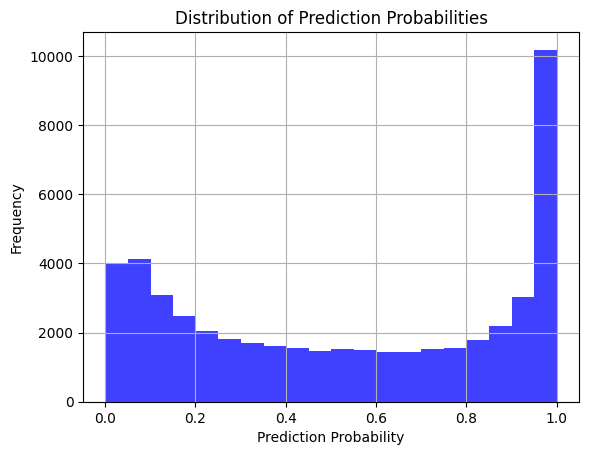

In [ ]:
import matplotlib.pyplot as plt

# Plotting the distribution of prediction probabilities
plt.hist(prediction_probabilities, bins=20, alpha=0.75, color='blue')
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
# Now, we will use np.unique to count unique values along with their counts
unique, counts = np.unique(predictions, return_counts=True)

# Combine the unique values and their counts into a dictionary
unique_counts = dict(zip(unique, counts))
unique_counts

{0: 23841, 1: 26159}

In [ ]:
shap.initjs()
import shap

# Assuming shap_values and X_test_shap are already defined
shap_values = explainer.shap_values(X_test_shap)

# Convert the force plot to HTML
force_plot = shap.force_plot(explainer.expected_value, shap_values[0], X_test_shap.iloc[0], show=False)

# Save the plot to an HTML file
shap.save_html('force_plot.html', force_plot)




100%|===================| 49858/50000 [03:32<00:00]       